# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment, you will be able to:

* perform Time Series Analysis and ARIMA Forecasting model for the prediction of the number of Airline Passengers

In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="400" controls>
  <source src="https://cdn.talentsprint.com/talentsprint1/archives/sc/misc/11_dec_2020_experiment_walkthrough.mp4" type="video/mp4">
</video>
""")

## Dataset

### Description

The dataset chosen for this experiment is  AirPassengers. This dataset provides monthly totals of a US airline passengers from 1949 to 1960. 

**Task Flow:**

Observation of trends, seasonality and noise

Making a Time Series Stationary

Forecasting Modeling -ARIMA

In [ ]:
! wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/AirPassengers.csv


### Import required Packages 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

### Load the Data

In [ ]:
# Read the AirPassengers dataset 
data = pd.read_csv('AirPassengers.csv',  parse_dates = True) 

In [ ]:
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# Convert Month object into datetime
data['Month'] = pd.to_datetime(data.Month)
data.set_index('Month', inplace=True)
df = data.sort_index(axis=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Before applying the model let us identify the trends and seasonality from the given time series data


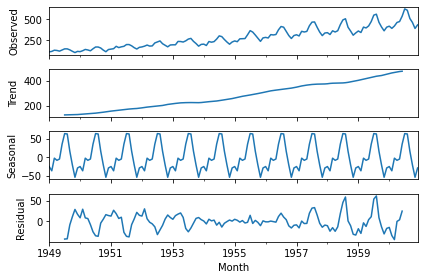

In [ ]:
# The statsmodels library provides a suite of functions for working with time series data
from statsmodels.tsa.seasonal import seasonal_decompose 

ts = data['Passengers']

# ETS Decomposition 
result = seasonal_decompose(ts) 

# ETS plot 
result.plot();

The seasonal decompose method broke down the data into three parts: trend, 
seasonality and residual components.

**Trend** – varying mean over time. **For eg.** the number of passengers is seen to be growing over time.

**Seasonality** – variations in specific time-frames. **For eg.** people may travel more in specific months owing to holidays/festivals.

**Residual Component (noise)** - We can see from the plot that there appears to be randomness in the data.

We can also perform Rolling Statistics to ensure whether the time series is stationary or not.

**Rolling Statistics:** Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time

In [ ]:
# Let’s create a function to run the test which determines whether a given time series is stationary
def get_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

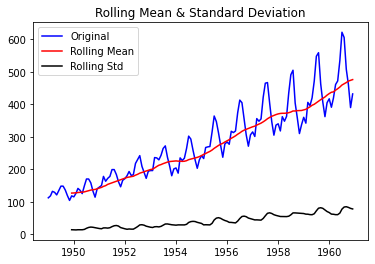

In [ ]:
get_stationarity(df)

As you can see, the rolling mean and rolling standard deviation increase with time. ***Therefore, it can be inferrred that the time series is not stationary.***

###Making the time series stationary
Stationarity is important because many useful analytical tools and statistical tests and models rely on it

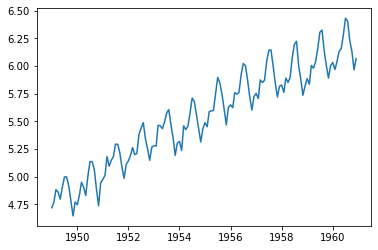

In [ ]:
# ESTIMATING THE TREND
# Applying a log transformation is a way to reduce the variance of the series
df_log = np.log(df)
plt.plot(df_log);

Eliminating the Trend and Seasonality by **Differencing** (taking the difference with a particular time lag)

In [ ]:
shift_df = pd.concat([df_log, df_log.shift(1)],axis=1)
shift_df.columns = ['Actual_Passengers','Forecasted_Passengers']
shift_df.head()

,Actual_Passengers,Forecasted_Passengers
Month,,
1949-01-01,4.718499,NaN
1949-02-01,4.770685,4.718499
1949-03-01,4.882802,4.770685
1949-04-01,4.859812,4.882802
1949-05-01,4.795791,4.859812


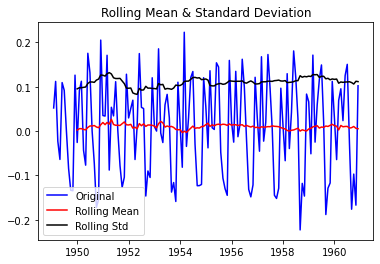

In [ ]:
# Taking the difference with a particular time lag
# We create a lagged copy of the data by subtracting the every previous data point from the current data point
df_log_shift = shift_df['Actual_Passengers'] - shift_df['Forecasted_Passengers']
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

You can see that the mean and standard deviation are approximately horizontal. We can also take second or third order differences which might get even better results in certain applications. However, it is still more stationary than the original.

In [ ]:
# Splitting the data into train and test sets
train_data, test_data = df_log[0:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
train_data.size, test_data.size

(115, 29)

Let us now apply the **ARIMA model (Autoregressive {p} Integrated {d} Moving Average {q}).** The model has 3 parameters

**p** - the parameter associated with the `Auto-Regressive part` of the ARIMA model. You can use the **PACF** (partial autocorrelation function) plot to find the optimal p value.

**d** - the parameter associated with the `Integration part` of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.

**q** - the parameter associated with the `Moving Average part` of the ARIMA model. You can use the **ACF** (autocorrelation function) plot to find the optimal q value.


These functions plot **lags** on the horizontal axis and the **correlations** on the vertical axis.


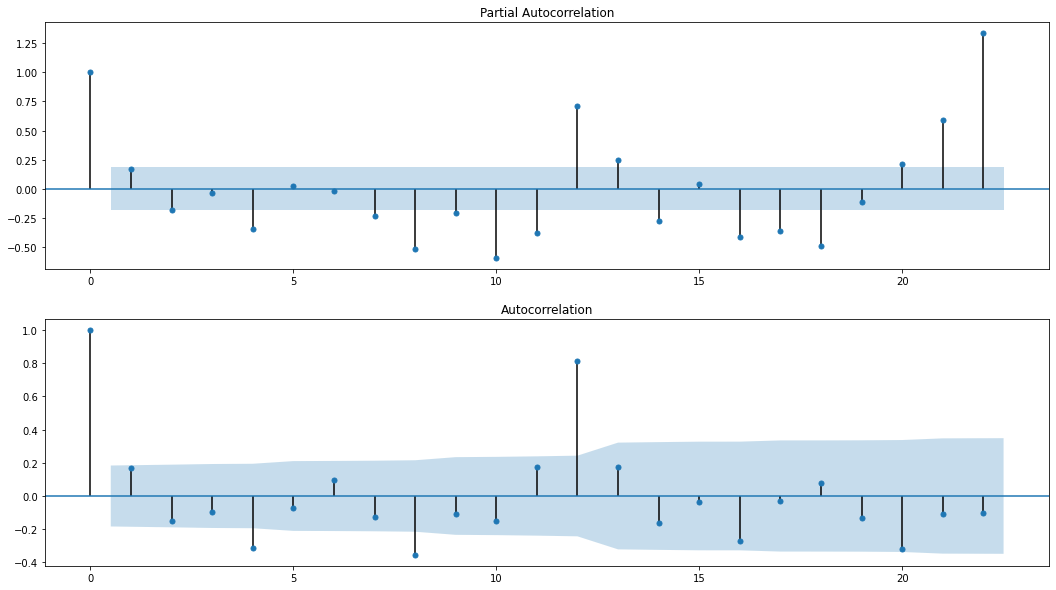

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf describes how well the present value of the series is related with its past values
# pacf finds correlation of the residuals of the current with the next lag value
trainData_diff = train_data.diff().dropna()
fig, ax = plt.subplots(2,1, figsize =(18, 10)) 
fig = plot_pacf(trainData_diff, lags=22, ax=ax[0])
fig = plot_acf(trainData_diff, lags=22, ax=ax[1]) 
plt.show()

AR model: The PACF plot finds the correlation with the residual (error) i.e. the component not explained by earlier lags.

    Order p is the lag value after which PACF plot crosses the upper confidence interval for the first time

MA model: The ACF plot finds the correlation of the current values with its lagged values

    Order q is the lag value after which ACF crosses the upper confidence interval for the first time.

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# ARIMA model
train_ar = train_data['Passengers'].values
test_ar = test_data['Passengers'].values

history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,1))
    # (1, 1, 1) indicates a lag value of 1 for autoregression, a difference order of 1 to make the time series stationary and a moving average model of 1.   
    model_fit = model.fit()        
    output = model_fit.forecast() # one-step forecast    
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)

error = sqrt(mean_squared_error(test_ar, predictions))
print('RMSE value: %.3f' % error)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE value: 0.115


### Plot the predictions

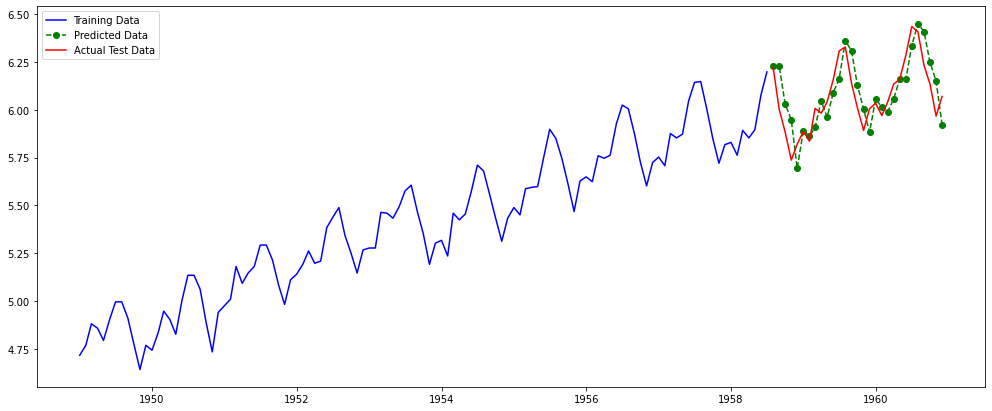

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(train_data['Passengers'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green',marker='o', linestyle='dashed', label='Predicted Data')
plt.plot(test_data.index, test_data['Passengers'], color='red', label='Actual Test Data')
plt.legend();

**References for Further Reading:**

[ACF and PACF plots](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=ACF%20is%20an%20(complete)%20auto,related%20with%20its%20past%20values)

[ARIMA model](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)


